In [7]:
import torch

x = torch.arange(4.0)
x

tensor([0., 1., 2., 3.])

In [8]:
x.requires_grad_(True)  # 等价于x=torch.arange(4.0,requires_grad=True)
x.grad  # 默认值是None


In [9]:
y = 2 * torch.dot(x, x)
y

tensor(28., grad_fn=<MulBackward0>)

In [10]:
y.backward()
x.grad

tensor([ 0.,  4.,  8., 12.])

In [11]:
x.grad == 4 * x

tensor([True, True, True, True])

In [12]:
# 在默认情况下，PyTorch会累积梯度，我们需要清除之前的值
x.grad.zero_()
y = x.sum()
y.backward()
x.grad

tensor([1., 1., 1., 1.])

In [133]:
# 对非标量调用backward需要传入一个gradient参数，该参数指定微分函数关于self的梯度。
# 本例只想求偏导数的和，所以传递一个1的梯度是合适的
x.grad.zero_()
y = x * x
y.sum().backward()# 等价于y.backward(torch.ones(len(x)))
x.grad

tensor([0., 2., 4., 6.], grad_fn=<ZeroBackward0>)

In [145]:
x.grad.zero_()
y = x * x
u = y.detach()
z = u * x

z.sum().backward()
x.grad == u

tensor([True, True, True, True])

In [146]:
x.grad.zero_()
y.sum().backward()
x.grad == 2 * x

tensor([True, True, True, True])

In [ ]:
def f(a):
    b = a * 2
    while b.norm() < 1000:
        b = b * 2
    if b.sum() > 0:
        c = b
    else:
        c = 100 * b
    return c

In [ ]:

a = torch.randn(size=(3,), requires_grad=True)
print(a)
d = f(a)
print(d)
d.sum().backward()
a.grad

tensor([-1.0613, -0.1213, -1.4029], requires_grad=True)
tensor([-108674.2812,  -12422.7490, -143659.2969], grad_fn=<MulBackward0>)


tensor([102400., 102400., 102400.])

练习3 如上 
1 需要改成d.sum().backward()或者d.backward(torch.ones_like(d))进行向量的求导
2 函数 f(a) 对 a 来说仍然是一个线性变换 d = k * a，所以梯度 a.grad 依然等于 d / a（逐元素），所有元素的值都等于同一个常量 k。

In [149]:
import torch

x = torch.tensor([0.0, 1.0, 2.0, 3.0], requires_grad=True)
z = x ** 4

# 1. 计算一阶导数
# 使用 create_graph=True 保留计算图，以便对导数再次求导
z.sum().backward(create_graph=True)
first_grad = x.grad.clone()  # 克隆一阶导数，避免后续操作覆盖它
print("一阶导数:", first_grad)

# 2. 计算二阶导数
# 清空梯度，准备计算二阶导数
x.grad.zero_()
# 对一阶导数的和进行反向传播，得到二阶导数
first_grad.sum().backward()
second_grad = x.grad
print("二阶导数:", second_grad)

一阶导数: tensor([  0.,   4.,  32., 108.], grad_fn=<CloneBackward0>)
二阶导数: tensor([  0.,  12.,  48., 108.], grad_fn=<ZeroBackward0>)


练习1   需要保留计算图，计算图复杂度翻倍

In [ ]:
#错误示例
x = torch.tensor([0.0, 1.0, 2.0, 3.0], requires_grad=True)
z=x*x*x*x
z.sum().backward(create_graph=True)
d1=x.grad   #缺少了 .clone() 没有正确克隆一阶导数，可能会导致后续操作覆盖它
print(d1)
#缺少x.grad.zero_()  梯度累积
d1.sum().backward()
x.grad

tensor([  0.,   4.,  32., 108.], grad_fn=<CopyBackwards>)


tensor([  0.,  16.,  80., 216.], grad_fn=<CopyBackwards>)

In [ ]:
import torch
x = torch.tensor([0.0, 1.0, 2.0, 3.0], requires_grad=True)
z=x*x*x*x
z.sum().backward(retain_graph=True)#梯度累计
z.sum().backward()#变成8x^3
x.grad

tensor([  0.,   8.,  64., 216.])

In [281]:
#新控制流梯度
def F(x):
    y=2*x
    while(y.sum()<10):
        y+=2.5
    if y.sum()>11:
        y-=3
    else:
        y+=0.005
    return y

In [280]:
a=torch.tensor([0.2,0,0.6,2],requires_grad=True)
print(F(a))
F(a).sum().backward()
a.grad

tensor([-0.1000, -0.5000,  0.7000,  3.5000], grad_fn=<SubBackward0>)


tensor([2., 2., 2., 2.])

练习4
y=[-0.1000, -0.5000,  0.7000,  3.5000], grad_fn=<SubBackward0>对应减法
梯度结果：a.grad 的输出是 tensor([2., 2., 2., 2.])。
结果解释：
这个梯度值 2 来源于函数 F(x) 的初始定义 y = 2 * x。
后续的 y += 2.5 和 y -= 3 操作，都是在 y 上加上或减去一个常数。在 PyTorch 的计算图中，对常数的加减操作不会影响梯度的传递，因为常数的导数为 0。
因此，整个函数 F(x) 对 x 的导数本质上就是初始线性变换 y = 2x 的导数，即  a.grad 中每个元素都是 2。

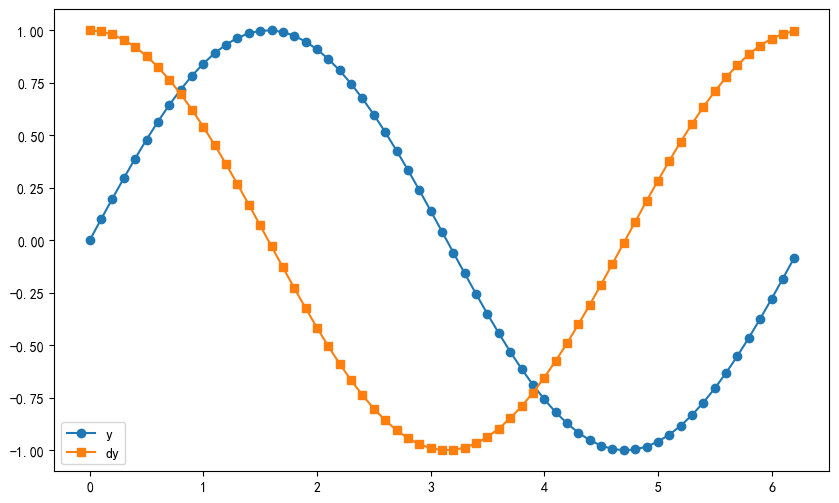

In [258]:
import matplotlib.pyplot as plt

x=torch.arange(0.0,2*torch.pi,0.1,requires_grad=True)
y=torch.sin(x)
if x.grad is not None:
    x.grad.zero_()
y.sum().backward()
dy=x.grad

x=x.detach().numpy()
y=y.detach().numpy()
dy=dy.detach().numpy()

plt.figure(figsize=(10,6))
plt.plot(x, y,'o-',label='y')
plt.plot(x, dy,'s-' ,label='dy')

plt.legend()
plt.show()


练习5
# ========== 解决中文乱码核心配置（必须放在绘图前） ==========
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']  # 指定中文黑体，兼容无黑体环境
plt.rcParams['axes.unicode_minus'] = False  # 关闭负号的unicode显示，避免负号变方框
# 横纵坐标标签（中文正常显示）
plt.xlabel('x 轴（0 ~ 2π）', fontsize=12)
plt.ylabel('y 轴 / 导数 dy', fontsize=12)